<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/staging/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# 前処理をまとめる
transform = transforms.Compose([
    # transforms.Resize((224, 224)), resnetの場合にのみ必要
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


In [4]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [5]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [6]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [7]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。

In [8]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 勾配の初期化
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.3621185266735152, acc: 0.5054582357406616,      val loss: 1.0262670560766713, val acc: 0.6425718665122986
epoch: 1, loss: 0.9055062314866067, acc: 0.68166184425354,      val loss: 0.850911219279987, val acc: 0.7088658213615417
epoch: 2, loss: 0.7334861011743088, acc: 0.7436620593070984,      val loss: 0.7603502111693922, val acc: 0.7367212176322937
epoch: 3, loss: 0.6287579187028163, acc: 0.7814699411392212,      val loss: 0.7132453659471993, val acc: 0.7535942196846008
epoch: 4, loss: 0.5524868483602123, acc: 0.8075016140937805,      val loss: 0.6877278186166629, val acc: 0.7620806694030762
epoch: 5, loss: 0.4935979156094107, acc: 0.828095018863678,      val loss: 0.7024452612994198, val acc: 0.7680710554122925
epoch: 6, loss: 0.4359419030910185, acc: 0.8471488952636719,      val loss: 0.7869391110948861, val acc: 0.7555910348892212
epoch: 7, loss: 0.39342217375205557, acc: 0.8604846596717834,      val loss: 0.7135351243586586, val acc: 0.7725638747215271
epoch: 8, l

In [9]:
labels

tensor([2, 1, 6, 6, 0, 2, 4, 0, 8, 9, 0, 6, 4, 5, 5, 4], device='cuda:0')

In [10]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


In [11]:
prob = prob_pred[:, 0]

In [12]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([1.4792e-06, 9.5452e-08, 3.7472e-09, 3.4219e-11, 9.8691e-01, 4.6633e-03,
        1.5095e-07, 9.8583e-01, 2.0793e-02, 1.0819e-05, 5.1878e-01, 1.5173e-09,
        1.9395e-07, 1.7308e-09, 2.9954e-10, 2.6734e-12], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [13]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

In [14]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0. 0. 0. 1.]
[0.         0.33333333 1.         1.        ]
[          inf 9.8690748e-01 5.1878071e-01 2.6733806e-12]


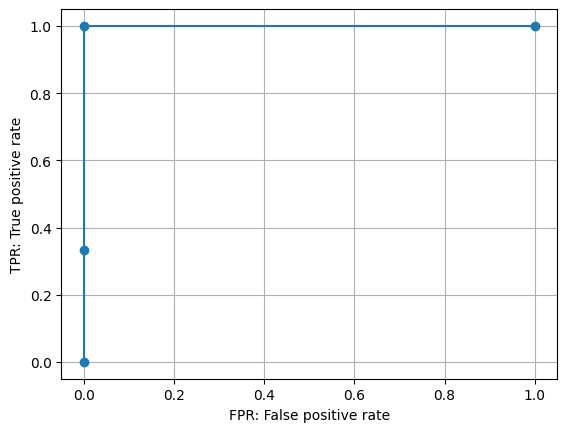

In [15]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [16]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.9206)
tensor(0.7529)
[[4647   12   98   36   28   14    7   15  106   37]
 [  25 4795    5   14    3    6   10    6   39   97]
 [  99   11 4453   92  115   88   74   34   25    9]
 [  46    7  108 4295   78  267  100   61   16   22]
 [  39    3  109   81 4548   72   43   78   19    8]
 [  16    7   86  291   78 4389   56   63    6    8]
 [  16   10   78   98   45   32 4690    6   11   14]
 [  26    1   50   57   75   67   15 4694    3   12]
 [  96   34   17   21    8    7   12    8 4766   31]
 [  39  107   16   21    6    9    9    9   33 4751]]
[[754  12  78  22  24  26   9  19  39  17]
 [ 10 882  15  10   1  12   5   5  15  45]
 [ 33   3 748  46  49  69  20  25   4   3]
 [ 12   5  67 574  55 211  26  43   4   3]
 [  7   1  99  58 716  45  16  52   5   1]
 [  7   1  61 123  25 727  11  44   1   0]
 [  5   1 100  89  27  44 728   5   1   0]
 [  6   2  35  32  45  66   5 808   0   1]
 [ 46  21  39  19   3  13   7   9 826  17]
 [ 29  84  16  19   5  25   5  26  24 767]]
[0.9294 

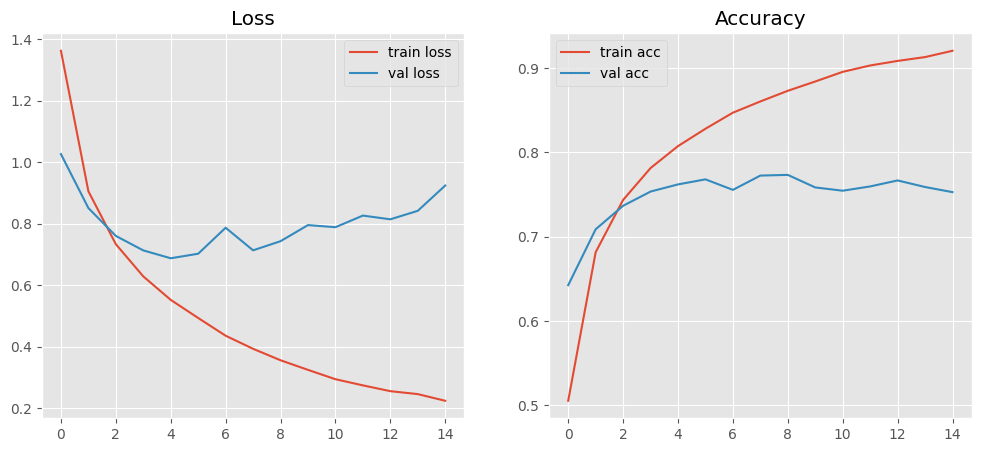

In [17]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [18]:
print(accs)
print(val_accs)

[tensor(0.5055), tensor(0.6817), tensor(0.7437), tensor(0.7815), tensor(0.8075), tensor(0.8281), tensor(0.8471), tensor(0.8605), tensor(0.8731), tensor(0.8841), tensor(0.8956), tensor(0.9031), tensor(0.9085), tensor(0.9131), tensor(0.9206)]
[tensor(0.6426), tensor(0.7089), tensor(0.7367), tensor(0.7536), tensor(0.7621), tensor(0.7681), tensor(0.7556), tensor(0.7726), tensor(0.7734), tensor(0.7585), tensor(0.7546), tensor(0.7597), tensor(0.7668), tensor(0.7590), tensor(0.7529)]


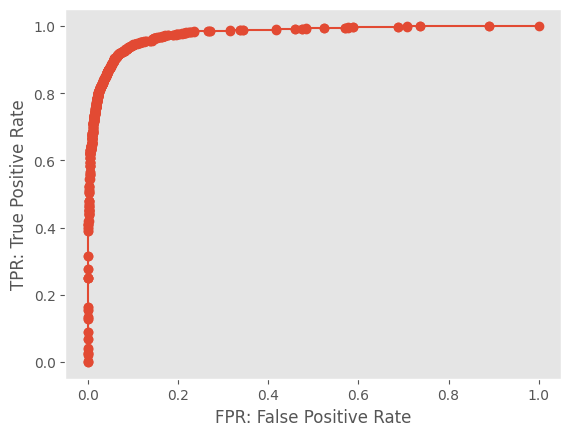

In [19]:
# y_val_true はラベル（0 or 1）を含むリスト
y_val_true = torch.tensor(y_val_true)

# val_output に softmax を適用
val_output_tensor = torch.cat([model(val_imgs.to(device)) for val_imgs, _ in validation_dataloader])
val_prob_pred = torch.softmax(val_output_tensor, dim=1)

# クラス0の確率値を取得
prob = val_prob_pred[:, 0].cpu().detach().numpy()

# 0/1 ラベルの取得
one_zero_labels = torch.where(y_val_true == 0, 1, 0).cpu().detach().numpy()

# ROC曲線の計算
fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

# グラフ描画
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
plt.grid()
plt.show()


ROC AUC Score: 0.9753
ROC AUC Score: 0.9898
ROC AUC Score: 0.9458
ROC AUC Score: 0.9179
ROC AUC Score: 0.9640
ROC AUC Score: 0.9451
ROC AUC Score: 0.9777
ROC AUC Score: 0.9792
ROC AUC Score: 0.9874
ROC AUC Score: 0.9825


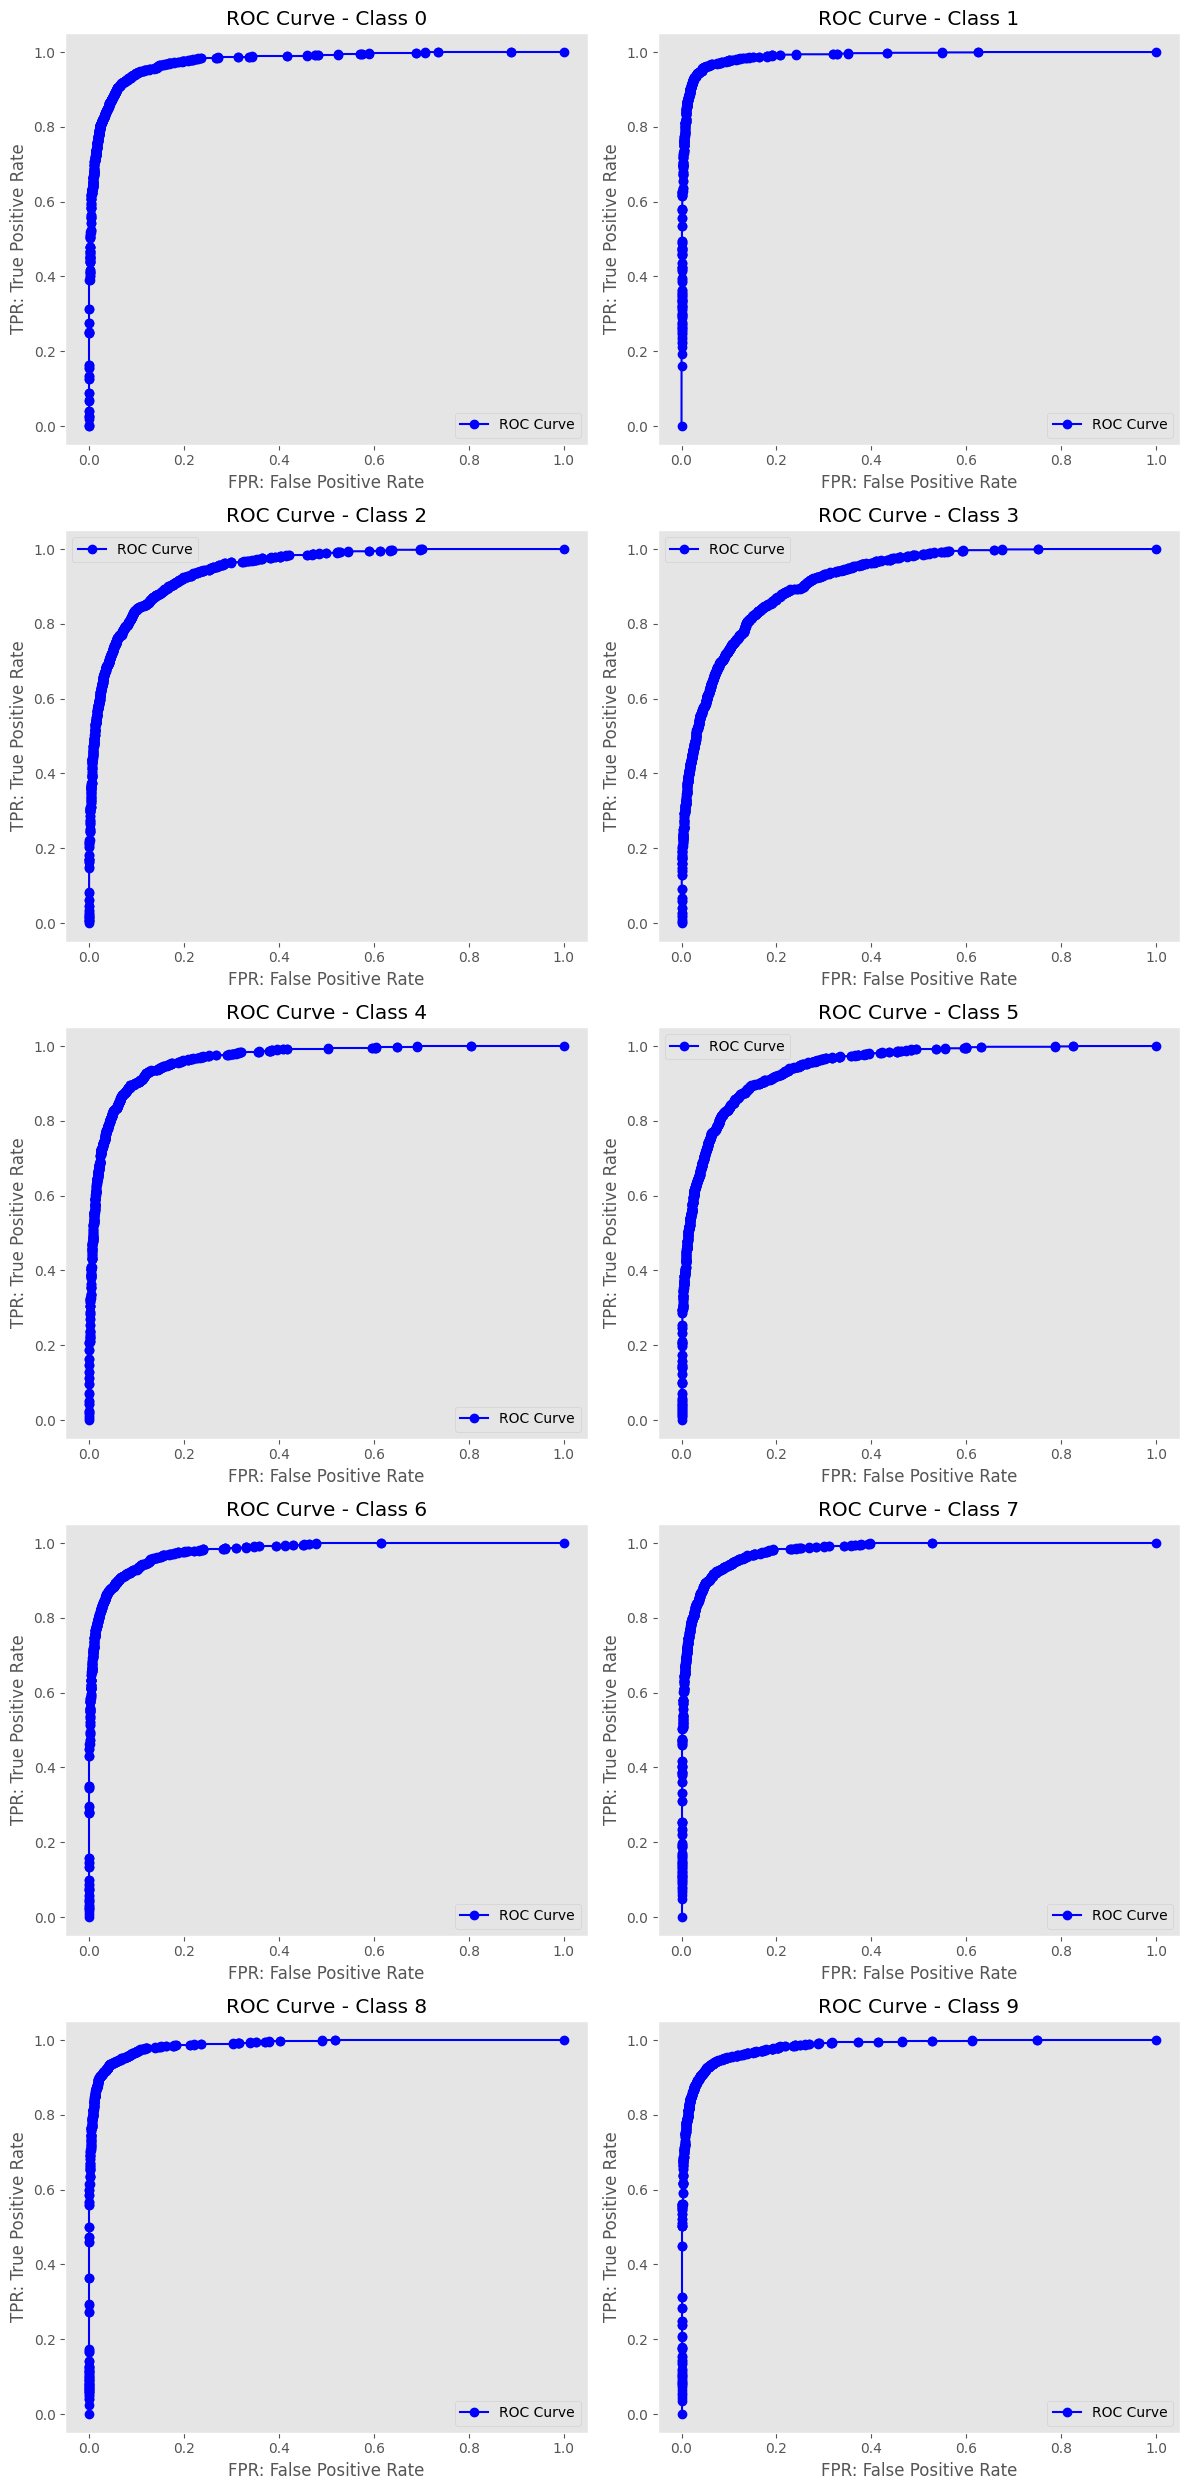

In [20]:
def make_roc_curve():
    fig, axes = plt.subplots(5, 2, figsize=(12, 25))  # 5行2列のサブプロット

    for n in range(10):

        # クラス0の確率値を取得
        prob = val_prob_pred[:, n].cpu().detach().numpy()

        # 0/1 ラベルの取得
        one_zero_labels = torch.where(y_val_true == n, 1, 0).cpu().detach().numpy()

        # ROC曲線の計算
        fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

        # auc算出
        auc_score = roc_auc_score(one_zero_labels, prob)
        print(f"ROC AUC Score: {auc_score:.4f}")

        # 行インデックスと列インデックスの計算
        row_idx = n // 2  # 行インデックス
        col_idx = n % 2   # 列インデックス

        # グラフ描画
        axes[row_idx, col_idx].plot(fpr, tpr, marker='o', color='b', label="ROC Curve")
        axes[row_idx, col_idx].set_xlabel('FPR: False Positive Rate')
        axes[row_idx, col_idx].set_ylabel('TPR: True Positive Rate')
        axes[row_idx, col_idx].set_title(f'ROC Curve - Class {n}')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].grid()
    plt.tight_layout()
    plt.show()

make_roc_curve()